In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clean-dataset/clean_new.csv


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import catboost as cb
from sklearn.neural_network import MLPRegressor

models = {
  'RandomForest': RandomForestRegressor(),
  'GradientBoosting': GradientBoostingRegressor(),
  'XGBoost': xgb.XGBRegressor(),
  'LightGBM': lgb.LGBMRegressor(),
  'CatBoost': cb.CatBoostRegressor(silent=True),
  "LinearRegression" : LinearRegression(),
  "MLP" : MLPRegressor()
  }

def results():
    result = []
    for name, model in models.items():
        mod = run_model(model,train,target)
        df = pd.DataFrame([run_model(model,train,target)])
        result.append(mod)

    df = pd.DataFrame(result)
    df.set_index('Model Name',inplace=True)

    plt.figure(figsize = (12,8))
    df['rmse'].plot()
    plt.title("RMSE per each model")
    plt.ylabel("RMSE")
    plt.show()

    return df


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, src, src_mask=None):
        src2, _ = self.self_attention(src, src, src, attn_mask=src_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.ffn(src)
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src


In [50]:
class Encoder(nn.Module):
    def __init__(self, d_model,num_layers= 5 , n_heads = 1 , d_ff = 2048, dropout=0.1):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)
        ])

    def forward(self, src, src_mask=None):
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

    # def get_params(self, deep=True):
    #     return {
    #         'num_layers': self.num_layers,
    #         'd_ff': self.d_ff,
    #         'dropout': self.dropout
    #     }

    # def set_params(self, **params):
    #     for param, value in params.items():
    #         setattr(self, param, value)
    #     self.model = self.forward()
    #     return self

class Scaling():
    """Treats data as series
    writing a function to apply this will 
    require input as a dataframe but apply as a pandas series"""

    def min_max_scaling(data):
        min_val = data.min()
        max_val = data.max()
        scaled_data = (data - min_val) / (max_val - min_val)
        return scaled_data
    
    def z_score_scaling(data):
        mean = data.mean()
        std_dev = data.std()
        scaled_data = (data - mean) / std_dev
        return scaled_data
    

    def robust_scaling(data):
        median = np.nanmedian(data)
        q1 = np.nanpercentile(data,0.25)
        q3 = np.nanpercentile(data,0.75)
        iqr = q3 - q1
        if np.all(np.isnan([iqr, median])):
            return data 
        iqr = np.where(iqr == 0, 10, iqr)
        scaled_data = (data - median) / iqr
        
        return scaled_data.fillna(0)


def preprocess_data(train_df,test_df=None,target=None,id=None):
    # self.combined_df = pd.concat([self.train_df.drop, self.test_df], axis=0)
    missing=train_df.isnull().sum().sort_values(ascending=False)
    missing=missing.drop(missing[missing==0].index)
    df = pd.DataFrame(missing)
    target = train_df[target]
    combined_df = pd.concat([train_df,test_df],axis=0)
    combined_df = combined_df.drop([id,target],inplace=True,axis=1)
    combined_df = combined_df.drop(missing.keys(),inplace=True,axis=1)
    
    return combined_df, target


class Tab_Former(nn.Module):
    """
    A model Using Encoders On Categorical Features And Scaling On Numerical Features
      And Also Displayinng It's Relationships With T-sne Plot  

      Args: 
        Combined_df, target,  random_seed
    """
    def __init__(self,combined_df,target, random_seed= 24):
        """Accepts datasets target it's Data Id"""
        super(Tab_Former, self).__init__()
        self.combined_df = combined_df
        # self.test_df = test_df
        self.target = target
        self.random_seed = random_seed
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # self.id = id
       
    
    def cat_num_split(self,combined_df):
        """
        Takes the combined_df and split it into categorical and numerical features respectively.

        Args:
            combined_df (DataFrame).

        Returns:
            Categorical features are object type and numerical features are float or integers.
        """

        # check the numbers of categorical features in train_df
        self.cat_cols = combined_df.select_dtypes(include='object').columns.tolist()
        cat_col_indices = list(combined_df.columns.get_loc(col) for col in self.cat_cols)
        # print(f"Number of categorical features: {len(cat_cols)}")

        # check the numbers of numeric features in train_df
        self.num_cols = combined_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        numeric_cols_indices = list(combined_df.columns.get_loc(col) for col in self.num_cols)
        # print(f"Number of numeric features: {len(numeric_cols)}")      
        
        
        return self.cat_cols, self.num_cols

    def feature_map(self):
        """
        Mapping each features to a unique value.

        Returns:
            Dictionary : Features and Maps (Dictionary).
        """
        kill = []
        for i in self.cat_cols:
            kill.append(list(self.combined_df[i].unique()))
        # print(kill)
            
        self.feature_mapping = {}
        idx = 0

        # Iterate over each list of categories
        for category_list in kill:
        # Iterate over each category in the list
            for category in category_list:
                # Assign unique index to the category and update the index
                self.feature_mapping[category] = idx
                idx += 1
        
        return self.feature_mapping

    def label_encode(self):
        """
        Encoding each features to a numerical labels.

        Returns:
            Pandas Series : Numerical labels.
        """
        lc = LabelEncoder()
        for i in self.cat_cols:
            # print(i)
            self.combined_df[i] = lc.fit_transform(self.combined_df[i])
            # print(self.combined_df[self.combined_df[i]].head())
        self.label_encoded = self.combined_df[self.cat_cols]
        # print(self.label_encoded)
        return self.label_encoded
    
    def encode(self,encoder = None,cat_col_embedding = None):
        
        """
        Encode Categorical Features.

        Args:
            encoder : Inbuilt encoder or your defined encoder.
            cat_col_embedding : Feature_map/label_encoder.

        Returns:
            DataFrame: Encoded Values.
        """
        # print("Mapped Cat_col",mapped_cat_col_indices_values_df.head())

        # Map the values in train_df to numerical indices using feature_map
        if cat_col_embedding == None:
            self.mapped_cat_col_indices_values_df = self.combined_df[self.cat_cols].applymap(lambda x: self.feature_mapping.get(x, x))

        else:
           self.mapped_cat_col_indices_values_df = self.label_encoded

        # print(self.mapped_cat_col_indices_values_df)
        if encoder:
            encoder = encoder
        else:
            encoder = Encoder(d_model=len(self.cat_cols)).to(self.device())

        # Example input tensor
        src_input = self.mapped_cat_col_indices_values_df.values
        src_input = torch.Tensor(src_input).to(self.device)
        # print("Source Input",src_input)

        new = []
        enc_values = []

        torch.manual_seed(self.random_seed)
        for i in np.arange(len(src_input)):
            new.append(encoder(src_input[i].unsqueeze(dim=0)).cpu().detach().numpy())


        for i in new:
            enc_values.append(i.squeeze())

        enc_values = pd.DataFrame(enc_values)
        # print(enc_values.head())
        # encoded = enc_values.values
        # print(enc_values[:5])
        enc_values.columns = self.cat_cols
        # print(enc_values.head())
        # enc_values = enc_values

        return enc_values


    def preprocess(self, scaling,encoded_values):
        """
        Encode Categorical Features.

        Args:
            scaling : Inbuilt encoder or your defined encoder.
            cat_col_embedding : Feature_map/label_encoder.

        Returns:
            DataFrame: train, test.
        """
        numeric_cols_indices_values_df = pd.DataFrame(self.combined_df[self.num_cols].values, columns=self.combined_df[self.num_cols].columns)
        # print("Continouns Variable\n",numeric_cols_indices_values_df.tail(2))

        # encoder = Encoder(d_model=len(self.cat_cols))  
        self.encoder = encoded_values
        # print(self.mapped_cat_col_indices_values_df.head())


        scale = numeric_cols_indices_values_df.apply(scaling)

        df = pd.concat([encoded_values,scale],axis=1)

        for i in df:
            if df[i].isnull().sum() == 0:
                continue
            else:
                df[i].fillna((df[i].mean()), inplace=True)

        print(df.isnull().sum())
        shape = df[df.columns[0]].shape[0]
        print('shape',shape)
        

        train = df[:shape] 
        test = df[shape:]

        return train, test
    
    def tsne_plot(self,encoded_values, values= 500):
        """
        Encode Categorical Features.

        Args:
            encoded_values : encoded values.
            values (int) : Numbers of features to plot.

        Returns:
            DataFrame: Encoded Values.
        """
        data_np = self.mapped_cat_col_indices_values_df.values[:values]

        # Perform dimensionality reduction using t-SNE
        tsne = TSNE(n_components=2,random_state=self.random_seed)
        data_tsne = tsne.fit_transform(data_np)

        # torch.manual_seed(24)
        # with torch.no_grad():
        #     encoded_data = encoder(src_input[:100])

        # Convert the encoded data to numpy array
        encoded_data_np = encoded_values.values[:values]

        # Perform dimensionality reduction using t-SNE
        tsne = TSNE(n_components=2,random_state=24)
        encoded_data_tsne = tsne.fit_transform(encoded_data_np)

        # Plot the 2D representations
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=np.arange(len(data_tsne)), cmap='plasma')
        plt.title('t-SNE 2D Representation of Original Data')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.colorbar(label='Data Point Index')

        plt.subplot(1, 2, 2)
        plt.scatter(encoded_data_tsne[:, 0], encoded_data_tsne[:, 1], c=np.arange(len(encoded_data_tsne)), cmap='plasma')
        plt.title('t-SNE 2D Representation')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.colorbar(label='Data Point Index')

        plt.tight_layout()
        plt.show()

    
def log_rmse(y_true, y_pred):
    # Apply the natural logarithm to the actual and predicted values
    log_y_true = np.log(y_true + 1)  # Adding 1 to avoid log(0) which is undefined
    log_y_pred = np.log(y_pred + 1)

    # Calculate the RMSE on the log scale
    rmse = np.sqrt(mean_squared_error(log_y_true, log_y_pred))
    return rmse

def run_model(model,train, target):

    X_train,X_test, y_train,y_test = train_test_split(train,target,test_size=0.25,random_state=24)
    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    model_r2_score = r2_score(y_train,y_train_pred)
    model_mse = mean_squared_error(y_train,y_train_pred)
    model_train_rmse = np.sqrt(model_mse)
    # model_log_rmse = log_rmse(y_train,y_train_pred)
    

    model_test_r2_score = r2_score(y_test,y_test_pred)
    model_test_mse = mean_squared_error(y_test,y_test_pred)
    model_test_rmse = np.sqrt(model_test_mse)
    # log_test_rmse = log_rmse(y_test,y_test_pred)

    print("Model Performance For Traning Set")
    print("--"*5)
    print("r2_score: ", model_r2_score)
    print("mean squared error: ", model_mse)
    print("rmse: ", model_train_rmse)
    # print("Log RMSE: ", model_log_rmse)
    print("--"*5)

    print("Model Performance For Test Set")
    print("--"*5)
    print("r2_score: ", model_test_r2_score)
    print("mean squared error: ", model_test_mse)
    print("rmse: ", model_test_rmse)
    # print("Test Log RMSE: ", log_test_rmse)
    print("--"*5)
    print(model)
    print("__"*5)

    model_name = model.__repr__()

    # Check if the length of the model name is greater than 20
    if len(model_name) > 20:
        # Take the first ten letters of the model name
        model_name = model_name[:10]

    return {"Model Name" : model_name,
            "r2_score" : model_test_r2_score.round(4),
            "mean squared error" : model_test_mse.round(4),
            "rmse" : model_test_rmse.round(4)}
            # "Log RMSE" : log_test_rmse.round(4)}




In [51]:
df[df.columns[0]].shape[0]

300261

In [48]:
df['airline'].shape[0]

300261

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
df = pd.read_csv('/kaggle/input/clean-dataset/clean_new.csv')
tab = Tab_Former(df, target = "price")
cat_col, num_col = tab.cat_num_split(df.drop(['index','price'],axis=1))
print("cat_col shape",cat_col)
print('num_col shape',num_col)
feature_map = tab.feature_map()
print('feature_map',feature_map)
mapp = len(feature_map)
print('map',mapp)
torch.manual_seed(24)
num_layer = 1
d_model = len(cat_col)
print(d_model)
encoder = Encoder(d_model=d_model,num_layers=num_layer,d_ff=128,dropout=0.8).to(device)
enc_val = tab.encode(encoder=encoder)


cuda
cat_col shape ['airline', 'ch_code', 'from', 'stop', 'to', 'Departure_time', 'Arrival_time', 'class']
num_col shape ['duration_time']
feature_map {'SpiceJet': 0, 'AirAsia': 1, 'Vistara': 2, 'GO FIRST': 3, 'Indigo': 4, 'Air India': 5, 'Trujet': 6, 'StarAir': 7, 'SG': 8, 'I5': 9, 'UK': 10, 'G8': 11, '6E': 12, 'AI': 13, '2T': 14, 'S5': 15, 'Delhi': 30, 'Mumbai': 25, 'Bangalore': 26, 'Kolkata': 27, 'Hyderabad': 28, 'Chennai': 29, 'non-stop ': 22, 'one': 23, 'two': 24, 'Afternoon': 38, 'Morning': 37, 'Early Morning': 40, 'Night': 39, 'Late Night': 36, 'economy': 41, 'business': 42}
map 32
8


/tmp/ipykernel_34/2936666311.py:170: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.mapped_cat_col_indices_values_df = self.combined_df[self.cat_cols].applymap(lambda x: self.feature_mapping.get(x, x))


In [54]:
print('Encoded Values',enc_val)
scale = Scaling.z_score_scaling
train, test = tab.preprocess(scaling = scale,encoded_values=enc_val)

Encoded Values          airline   ch_code      from      stop        to  Departure_time  \
0      -1.648899 -1.070405 -0.145091  0.879081 -0.395726        0.255924   
1      -1.574016 -1.186450 -0.120643  0.896542 -0.362872        0.218477   
2      -1.477855 -0.897684  0.625264  0.045093  0.262657       -1.113388   
3      -1.629659 -0.949511  0.742693 -0.397875 -0.553739        0.525963   
4      -1.822573 -1.202122  0.349003 -0.271447 -0.038778        0.891897   
...          ...       ...       ...       ...       ...             ...   
300256 -1.541394 -1.076361  0.069007 -0.292688 -0.366276        0.671833   
300257 -1.434991 -0.851141  0.492205  0.067991  0.421503       -1.235432   
300258  1.575615 -1.656166 -0.089587 -0.584296 -0.172038       -0.873191   
300259 -1.448136 -0.883328  0.458091  0.034485  0.387490       -1.159211   
300260 -1.476173 -1.051675 -0.043494 -0.361867 -0.096557        0.381003   

        Arrival_time     class  
0           1.718811  0.406305  
1     

In [ ]:
train.to_csv('train.csv')
test.to_csv('test.csv')

In [83]:
def strip(data):
    data = data.replace(',','')
    return data

In [84]:
df['price'] = df['price'].apply(strip)

In [87]:
df['price']=pd.to_numeric(df['price'], errors='coerce')

In [98]:
target = np.log(df['price'])

In [99]:
target

0          8.691651
1          8.691651
2          8.692154
3          8.691986
4          8.691986
            ...    
300256    11.145695
300257    11.252923
300258    11.278456
300259    11.309401
300260    11.309401
Name: price, Length: 300261, dtype: Float64

In [115]:
X_test,X_train, y_test,y_train = train_test_split(train,target,test_size=0.75,random_state=None)

In [116]:
X_train.head()

,airline,ch_code,from,stop,to,Departure_time,Arrival_time,class,duration_time
278536,-1.910530,-1.032308,0.154130,-0.219584,-0.070098,0.976302,0.901559,1.200530,-0.610012
201145,-1.812185,-1.091949,0.298420,-0.192298,-0.305482,0.870925,0.952711,1.279857,-0.679525
227327,-1.408879,-0.984607,-0.189095,-0.295163,-0.311347,0.447314,2.029294,0.712484,0.271405
32850,-1.883947,-1.091545,-0.040536,1.492955,-0.175353,0.431325,0.566142,0.700959,-0.227694
235924,-1.404948,-0.857093,0.727939,0.033172,0.307100,-1.269382,1.128883,1.334329,0.397918


In [117]:
X_test.head()

,airline,ch_code,from,stop,to,Departure_time,Arrival_time,class,duration_time
186838,-1.592743,-1.106154,0.513638,-0.376271,-0.254311,0.475260,0.536084,1.804497,0.189380
173859,-1.350310,-0.847046,-0.000891,1.290629,-0.057302,-1.101498,0.563212,1.503206,1.394725
153750,-1.863278,-1.261006,0.169389,-0.207031,0.319957,0.922228,0.771660,1.148080,-0.597500
264693,-0.689184,-0.546692,-0.721522,-0.368576,2.558938,-0.101403,-0.101403,-0.030157,0.050356
75618,-1.488474,-1.067994,0.145266,-0.384715,-0.121916,0.351124,2.005345,0.561363,-0.853306


In [118]:
y_train.head()

278536    11.134691
201145     7.765993
227327    10.985649
32850      8.660774
235924    11.071082
Name: price, dtype: Float64

In [119]:
y_train.tail()

164072    8.254269
84525     9.200694
101454    8.789965
151247     7.99497
74         9.59356
Name: price, dtype: Float64

In [120]:
y_test.tail()

88563      8.321422
52110      8.254009
135897     8.825266
77555      9.333177
266585    10.825184
Name: price, dtype: Float64

Model Performance For Traning Set
----------
r2_score:  0.9277801690999227
mean squared error:  0.08941138234412764
rmse:  0.29901736127544104
----------
Model Performance For Test Set
----------
r2_score:  0.5707646942264374
mean squared error:  0.5320077562850232
rmse:  0.729388618148805
----------
RandomForestRegressor()
__________
Model Performance For Traning Set
----------
r2_score:  0.9277416407510288
mean squared error:  0.08945908216412306
rmse:  0.2990971115944169
----------
Model Performance For Test Set
----------
r2_score:  0.570390492696901
mean squared error:  0.5324715534458095
rmse:  0.72970648444824
----------
RandomForestRegressor()
__________
Model Performance For Traning Set
----------
r2_score:  0.21255597050400699
mean squared error:  0.9748909450270035
rmse:  0.9873656592301575
----------
Model Performance For Test Set
----------
r2_score:  0.21212899858398937
mean squared error:  0.9765121323139364
rmse:  0.9881862842166634
----------
GradientBoostingRegressor(

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Performance For Traning Set
----------
r2_score:  0.2856969428172801
mean squared error:  0.8843391483941438
rmse:  0.9403930818514904
----------
Model Performance For Test Set
----------
r2_score:  0.28342864075370733
mean squared error:  0.8881411103024173
rmse:  0.9424123886613637
----------
MLPRegressor()
__________


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Performance For Traning Set
----------
r2_score:  0.25825865988137886
mean squared error:  0.9183089704758733
rmse:  0.9582843891433656
----------
Model Performance For Test Set
----------
r2_score:  0.2560151037288879
mean squared error:  0.9221183114511603
rmse:  0.9602699159357021
----------
MLPRegressor()
__________


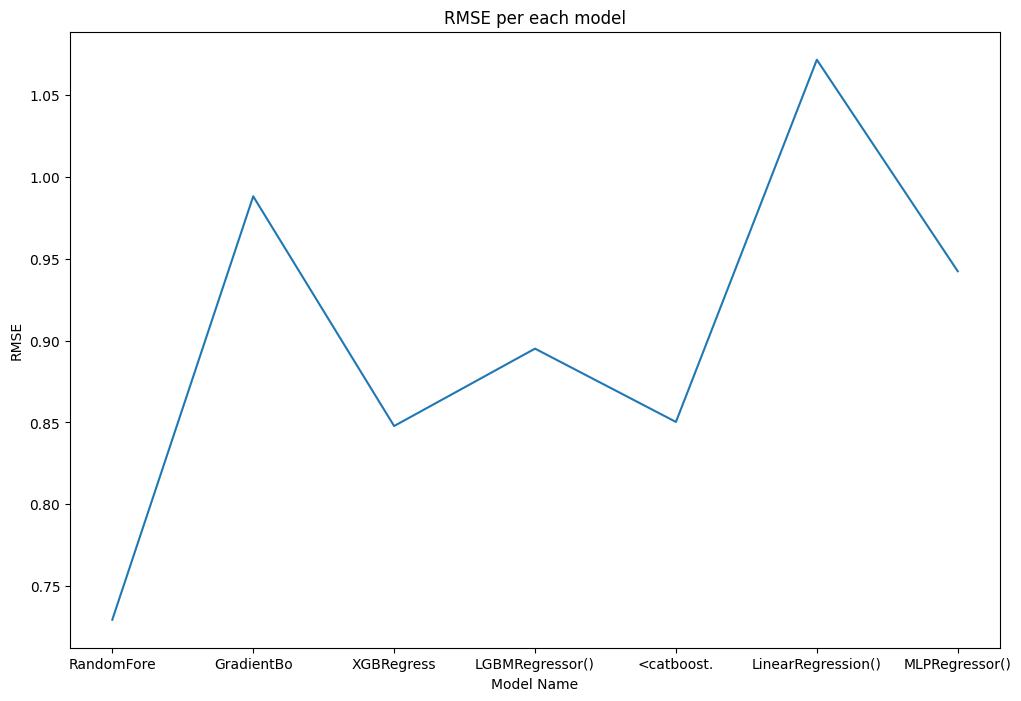

,r2_score,mean squared error,rmse
Model Name,,,
RandomFore,0.5708,0.5320,0.7294
GradientBo,0.2121,0.9765,0.9882
XGBRegress,0.4201,0.7188,0.8478
LGBMRegressor(),0.3535,0.8013,0.8951
<catboost.,0.4166,0.7231,0.8503
LinearRegression(),0.0733,1.1486,1.0717
MLPRegressor(),0.2834,0.8881,0.9424


In [121]:
results()

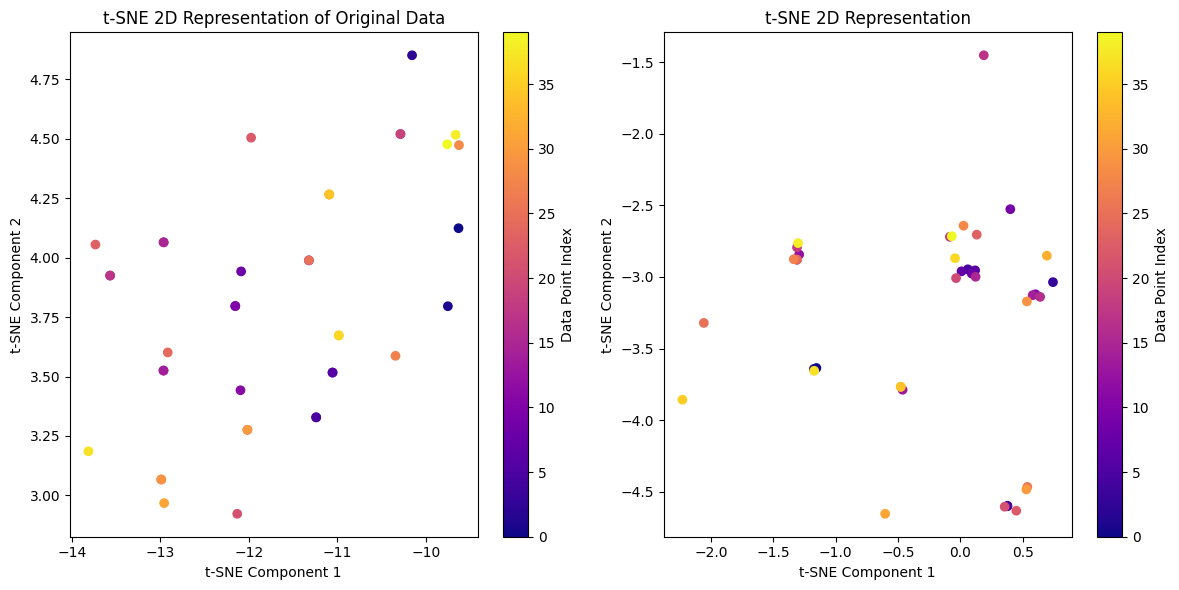

In [125]:
 tab.tsne_plot(enc_val, values= 40)

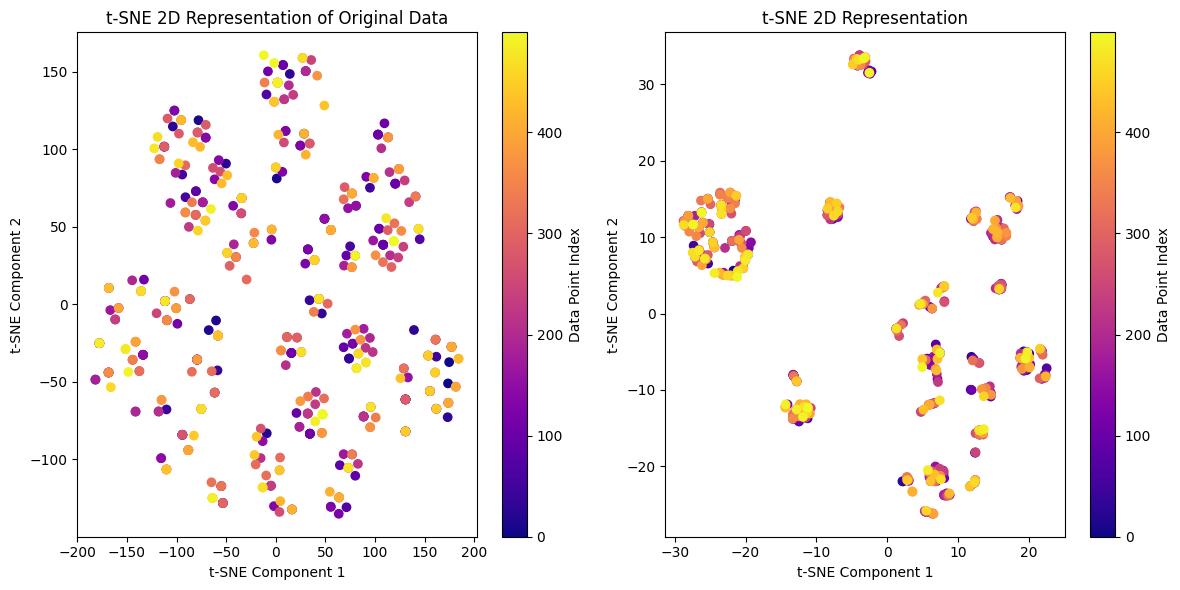

In [126]:
 tab.tsne_plot(enc_val, values= 500)

In [133]:
from sklearn.decomposition import PCA

def plot_words(embedding, sequences, sentence):
    pca = PCA(n_components=2)
    X_pca_train = pca.fit_transform(embedding[sentence,0:len(sequences[sentence]),:])


    fig, ax = plt.subplots(figsize=(12, 6)) 
    plt.rcParams['font.size'] = '12'
    ax.scatter(X_pca_train[:, 0], X_pca_train[:, 1])
    words = list(feature_map.keys())
    for i, index in enumerate(sequences[sentence]):
        ax.annotate(words[index-1], (X_pca_train[i, 0], X_pca_train[i, 1]))



In [139]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

def plot_words(embedding, sequences, sentence):
    """
    Plot PCA-transformed word embeddings for a specific sentence.

    Parameters:
    - embedding: 3D numpy array of shape (num_sentences, num_words, embedding_dim)
    - sequences: list of lists, where each inner list contains the words in a sentence
    - sentence: int, index of the sentence to visualize
    """
    # Apply PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2)
    X_pca_train = pca.fit_transform(embedding[sentence, :len(sequences[sentence]), :])

    # Create a scatter plot
    fig, ax = plt.subplots(figsize=(12, 6)) 
    plt.rcParams['font.size'] = '12'
    ax.scatter(X_pca_train[:, 0], X_pca_train[:, 1])

    # Annotate the points with corresponding words
    for i, word in enumerate(sequences[sentence]):
        ax.annotate(word, (X_pca_train[i, 0], X_pca_train[i, 1]))

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'PCA of Word Embeddings for Sentence {sentence}')
    plt.show()


In [134]:
cat = df[cat_col]

In [149]:
list_of_lists = [array.tolist() for array in cat.values]

In [ ]:
plot_words(enc_val, list_of_lists, 0) 

In [ ]:
plot_words(enc_val,cat.values,2)